In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import os

In [117]:
import google.colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Input Data

In [118]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

"""#Mount google drive"""

DATASET_ROOT = "/content/drive/MyDrive/Pytorch/Image_classification"

Using device: cuda


In [119]:
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")
NUM_CLASSES = 3        # You said 3 categories
IMG_SIZE = 128         # Can change to 224 if needed

# Transformation and Dataset DataLoader

In [120]:
from torchvision import transforms
from torchvision.models import ViT_B_16_Weights

# Base ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# TRAIN transform (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# TEST / VAL transform (NO augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Dataset DataLoader

In [121]:
train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_DIR,
    transform=test_transform
)

Use this when images aren't in image form

```
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)
    #now it is (C,H,W) -> (H,W,C)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

train_dataset = CustomDataset(root=TRAIN_DIR, transform=custom_transform)
test_dataset = CustomDataset(root=TEST_DIR, transform = custom_transform)
```



In [122]:
#DtaLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [123]:
print("Class mapping:", train_dataset.class_to_idx)

Class mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}


#**Model**

link: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16

In [124]:
import torchvision.models as models

ViT16 = models.vit_b_16(pretrained = True)

#It expects
```
models.vit_b_16(pretrained=True)
```
which expects 224×224.

In [125]:
ViT16

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [126]:
for param in ViT16.parameters():
  param.requires_grad = False

In [127]:
ViT16.heads.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 3)
)

#**Training**

In [128]:
learning_rate = 0.0005
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViT16.heads.head.parameters(), lr=learning_rate)
ViT16 = ViT16.to(device)

In [129]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = ViT16(batch_features)

    print(outputs.shape)
    print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

    break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


torch.Size([32, 3])
torch.Size([32])
Epoch: 1 , Loss: 0.13928145170211792
torch.Size([32, 3])
torch.Size([32])
Epoch: 2 , Loss: 0.1376403570175171
torch.Size([32, 3])
torch.Size([32])
Epoch: 3 , Loss: 0.13428720831871033
torch.Size([32, 3])
torch.Size([32])
Epoch: 4 , Loss: 0.13432933390140533
torch.Size([32, 3])
torch.Size([32])
Epoch: 5 , Loss: 0.12885639071464539
torch.Size([32, 3])
torch.Size([32])
Epoch: 6 , Loss: 0.12777307629585266
torch.Size([32, 3])
torch.Size([32])
Epoch: 7 , Loss: 0.12853017449378967
torch.Size([32, 3])
torch.Size([32])
Epoch: 8 , Loss: 0.12176422029733658
torch.Size([32, 3])
torch.Size([32])
Epoch: 9 , Loss: 0.11879494041204453
torch.Size([32, 3])
torch.Size([32])
Epoch: 10 , Loss: 0.10923904180526733
torch.Size([32, 3])
torch.Size([32])
Epoch: 11 , Loss: 0.10912363976240158
torch.Size([32, 3])
torch.Size([32])
Epoch: 12 , Loss: 0.10766805708408356
torch.Size([32, 3])
torch.Size([32])
Epoch: 13 , Loss: 0.09527279436588287
torch.Size([32, 3])
torch.Size([32]

#**Evaluation**

In [130]:
ViT16.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [131]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = ViT16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.92


In [132]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = ViT16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9866666666666667


In [133]:
model_save_path = os.path.join(DATASET_ROOT, 'ViT16.onnx')
torch.save(ViT16.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Pytorch/Image_classification/ViT16.onnx


In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
print("Seaborn and Matplotlib imported.")

Seaborn and Matplotlib imported.


In [135]:
ViT16.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = ViT16(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Overall accuracy
overall_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

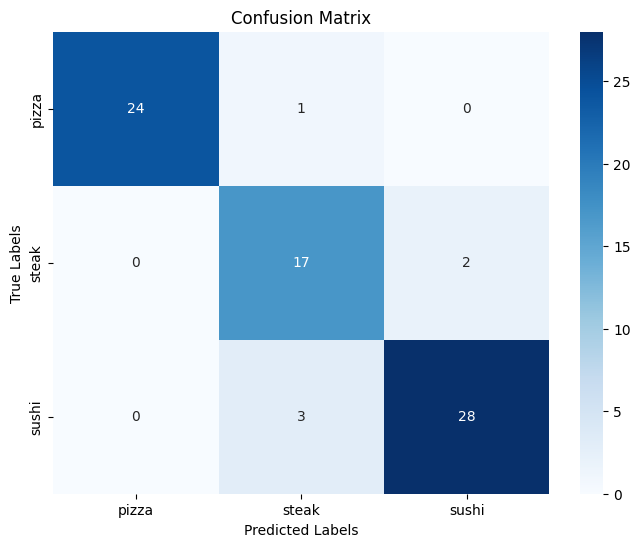

Total Accuracy: 0.9200

Accuracy per category:
  pizza: 0.9600
  steak: 0.8947
  sushi: 0.9032


In [136]:
class_names = list(train_dataset.class_to_idx.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"Total Accuracy: {overall_accuracy:.4f}")

print("\nAccuracy per category:")
for i, class_name in enumerate(class_names):
    true_positives = conf_matrix[i, i]
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives
    total_actual = true_positives + false_negatives

    if total_actual > 0:
        accuracy = true_positives / total_actual
        print(f"  {class_name}: {accuracy:.4f}")
    else:
        print(f"  {class_name}: No true instances in test set")


In [137]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
print(f"Index to class mapping: {idx_to_class}")

# Initialize a dictionary to store indices for each class
class_to_indices = {class_id: [] for class_id in range(len(idx_to_class))}

# Populate class_to_indices by iterating through the test_dataset
for i, (_, label) in enumerate(test_dataset):
    class_to_indices[label].append(i)

print("Class to indices mapping populated successfully.")

Index to class mapping: {0: 'pizza', 1: 'steak', 2: 'sushi'}
Class to indices mapping populated successfully.



Processing class: pizza

Processing class: steak

Processing class: sushi


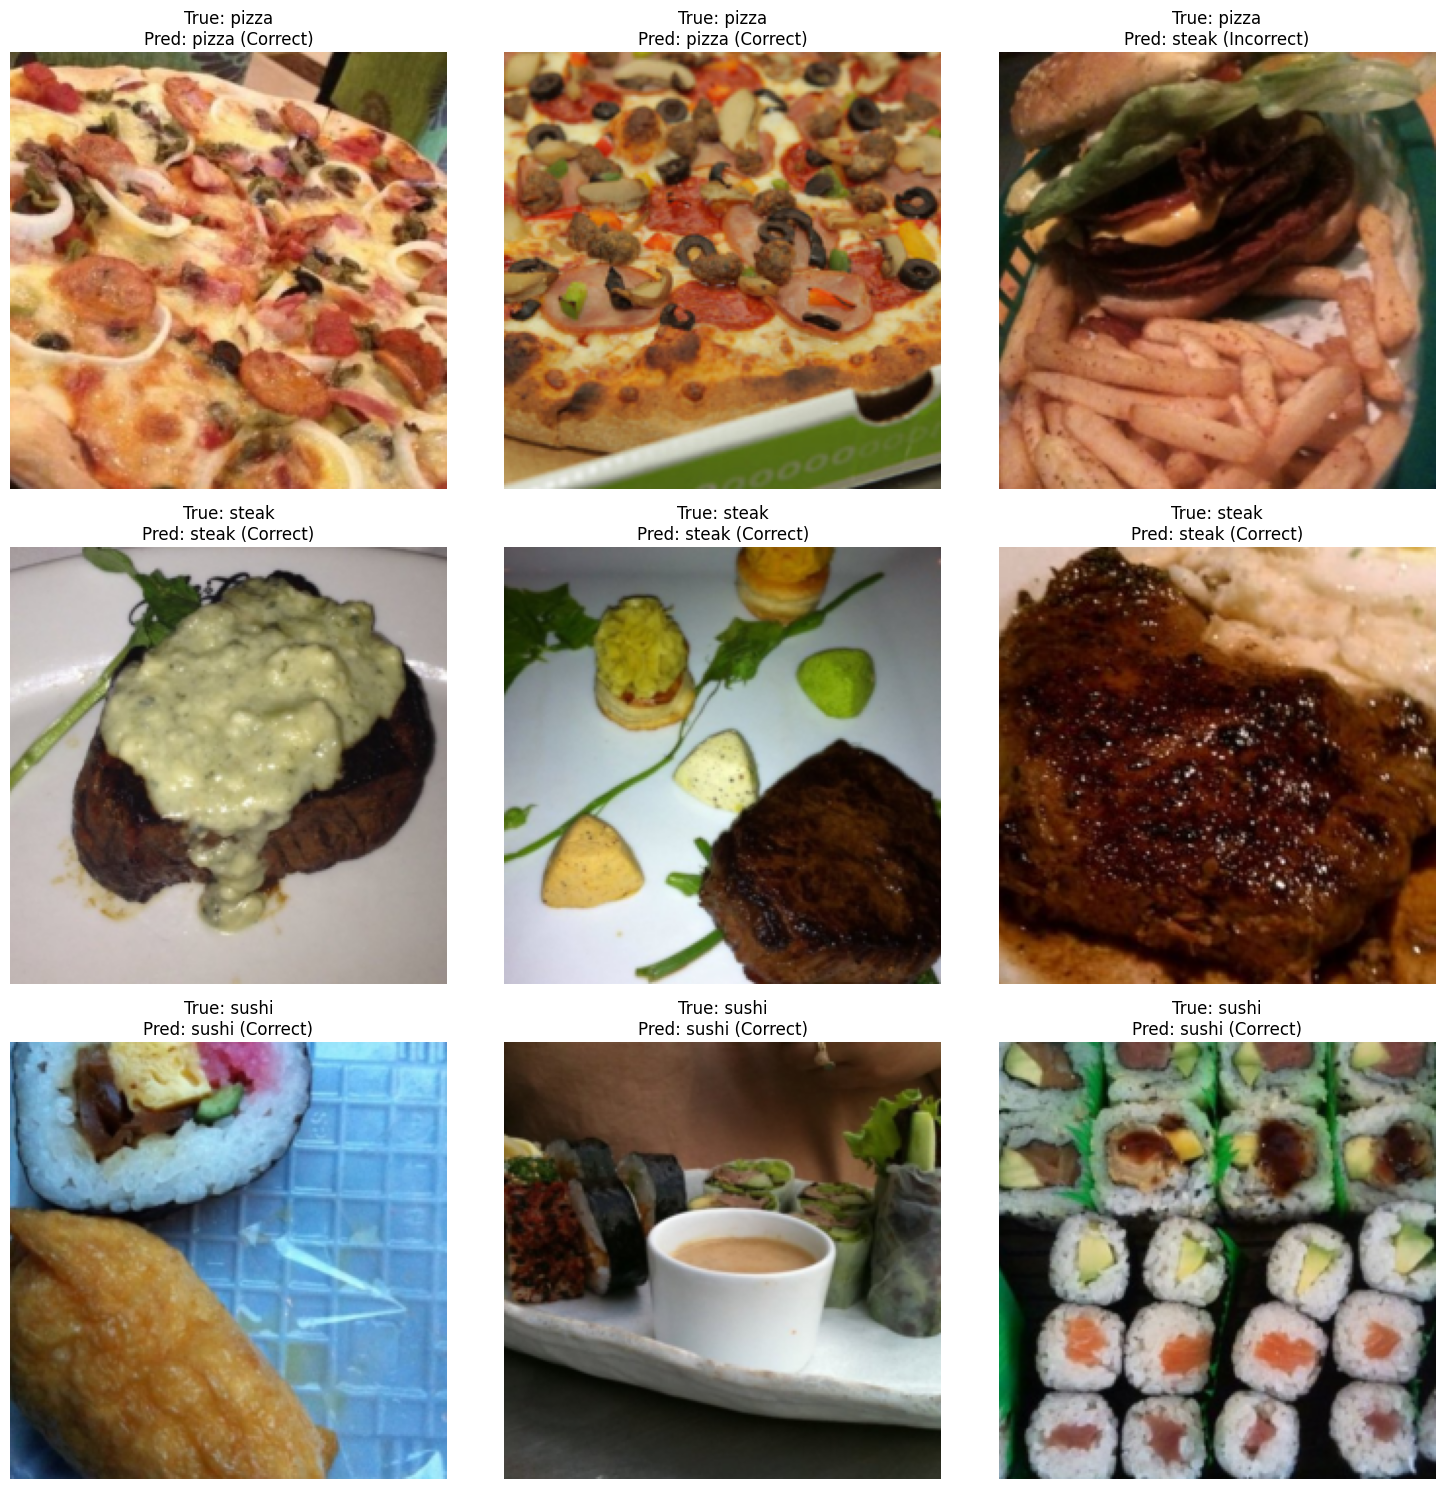

Sample image predictions and visualizations completed.


In [138]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure the model is in evaluation mode (it was already set in a previous cell, but good practice to reiterate)
ViT16.eval()

# Denormalization for display (optional, but good for visual clarity)
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Number of images to select per class
num_samples_per_class = 3

plt.figure(figsize=(15, 5 * len(idx_to_class)))

# Iterate through each class
for class_id, class_name in idx_to_class.items():
    # Get all indices for the current class in the test dataset
    indices = class_to_indices[class_id]

    # Randomly select num_samples_per_class images, or all if fewer are available
    selected_indices = random.sample(indices, min(len(indices), num_samples_per_class))

    print(f"\nProcessing class: {class_name}")

    for i, img_idx in enumerate(selected_indices):
        # Get the image and true label from the test_dataset
        image_tensor, true_label = test_dataset[img_idx]

        # Move the image to the device and add a batch dimension
        input_image = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = ViT16(input_image)
            _, predicted_label_tensor = torch.max(outputs, 1)
            predicted_label = predicted_label_tensor.item()

        # Convert image tensor for display
        display_image = denormalize_image(image_tensor).cpu().numpy().transpose(1, 2, 0)
        display_image = np.clip(display_image, 0, 1) # Clip values to [0,1] for display

        true_class_name = idx_to_class[true_label]
        predicted_class_name = idx_to_class[predicted_label]
        is_correct = "Correct" if true_label == predicted_label else "Incorrect"

        # Plot the image
        plt.subplot(len(idx_to_class), num_samples_per_class, class_id * num_samples_per_class + i + 1)
        plt.imshow(display_image)
        plt.title(f"True: {true_class_name}\nPred: {predicted_class_name} ({is_correct})")
        plt.axis("off")

plt.tight_layout()
plt.show()

print("Sample image predictions and visualizations completed.")